# Week 2 - Polynomial Curve Fitting and Decision Theory

### Jonas Lund, 201906201, 15/09/2022

Learning contents:

1. Linear models
    - Linear function
    - Error function
    - Root meant square error
    - Optimization of Error function
    - Test the model
2. Regularization
    - Error function
    - Optimization
    - Test with regularization
3. Model Selection
    - Cross-validation
4. Bayesian curve fitting
    - Display results

## Description

In this exercise we will apply Linear Models for Polynomial Curve Fitting task.

You have to fill empty functions (with pass in body) to match their purpose.

1. You have to create a code for evaluation of a Linear Model, it's error functions and finding optimal weights with given error functions.
2. You need to add regularization to the optimization procedure.
3. You need to implement Cross-validation model selection technique.
4. You need to implement Bayesian curve fitting, computing phi and S matricies at first, then using them to compute mean and variance.

## Dependencies

In [8]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from math import  exp

import seaborn as sns; sns.set(); sns.set_palette('bright')

## Generate Data

In [2]:
def target_func(x): return np.sin(2*np.pi*x)

def generate_data(size):
    rng = np.random.RandomState(26052605)
    x_train = rng.uniform(0., 1., size)
    y_train = target_func(x_train) + rng.normal(scale=0.1, size=size)
    x_test = np.linspace(0., 1., 100)
    y_test = target_func(x_test)
    
    return x_train, y_train, x_test, y_test

x_train, y_train, x_test, y_test = generate_data(10)

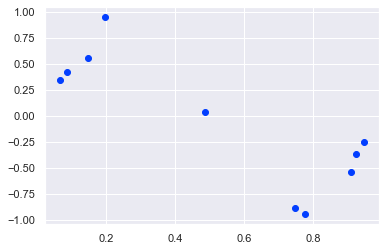

In [3]:
plt.scatter(x_train, y_train)

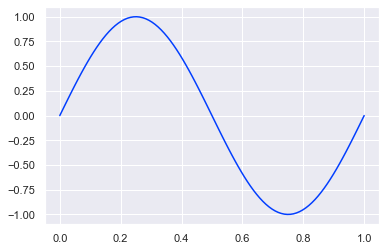

In [4]:
plt.plot(x_test, y_test, '-')

## 1) Linear models

### 1.1) Linear function

`linear` takes data point `x` and a list of `weights` as parameters 

The linear model for polynomial curve fitting is $$y(x,\mathbf{w}) = \sum^M_{j=0} w_jx^j$$

In [5]:
def linear(x, weights):
    M = len(weights)
    res = sum([
        weights[j] * x**j
        for j in range(M)
    ])
    return res

### 1.2) Error function

`err` is a sum-of-squares error function that takes `weights`, `inputs` and `targets` as parameters

The sum-of-squares error function is $$E(\mathbf{w},\mathbf{x},\mathbf{t}) = E(\mathbf{w}) = \dfrac12\sum^N_{n=1}\{y(x_n, \mathbf{w}) − t_n\}^2$$

In [6]:
def err(weights, inputs, targets):
    assert(len(inputs) == len(targets))
    N = len(inputs)
    res = 0.5 * sum([
        (linear(inputs[n], weights) - targets[n])**2
        for n in range(N)
    ])
    return res

### 1.3) Root-mean-square error

The RMS error is defined by $$E_{RMS} = \sqrt{2 E(\mathbf{w}^\star) / N}$$

In [13]:
def erms(weights, inputs, targets):
    assert(len(inputs) == len(targets))
    N = len(inputs)
    res = np.sqrt(2 * err(weights, inputs, targets) / N)
    return res

### 1.4) Optimization of Error function

`optimal_weights` takes `inputs`, `targets`, and `M` (number of weights) as parameters and returns optimal weights for this data

In [10]:
def optimal_weights(inputs, targets, M):
    assert(len(inputs) == len(targets))
    X = np.array([
        [
            x**j
            for j in range(M + 1)
        ] 
        for x in inputs
    ])
    res = np.linalg.pinv(X.T @ X) @ X.T @ np.array(targets)
    return res


### 1.5) Test the model

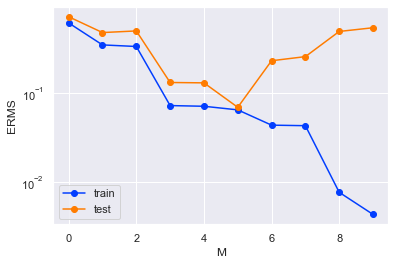

In [15]:
def test_all(start_M, end_M, x_train, y_train, x_test, y_test):
    
    results_train = []
    results_test = []
    all_weights = []
    
    for M in range(start_M, end_M + 1):
        weights = optimal_weights(x_train, y_train, M)
        all_weights.append(weights)
        error_train = erms(weights, x_train, y_train)
        error_test = erms(weights, x_test, y_test)
        results_train.append(error_train)
        results_test.append(error_test)
    return results_train, results_test, all_weights

r_tr, r_tt, all_weights = test_all(0, 9, x_train, y_train, x_test, y_test)

plt.plot(list(range(0, 10)), r_tr, '-o', label='train')
plt.plot(list(range(0, 10)), r_tt, '-o', label='test')
plt.xlabel('M')
plt.ylabel('ERMS')
plt.legend()
plt.yscale('log')

##### Weights table for different `M`

In [16]:
print(pd.DataFrame(all_weights))

          0           1            2             3             4  \
0 -0.067444         NaN          NaN           NaN           NaN   
1  0.674906   -1.403250          NaN           NaN           NaN   
2  0.870601   -2.937208     1.521622           NaN           NaN   
3 -0.348533   11.654727   -33.094539     22.088529           NaN   
4 -0.274931   10.447965   -27.877273     14.161034      3.897826   
5  0.052313    2.957062    24.077616   -126.364848    164.358999   
6  1.343704  -29.263453   282.780683  -1019.109754   1661.058925   
7  1.660039  -39.467224   401.668911  -1667.842830   3460.327268   
8 -2.483986  104.743862 -1467.659513  10144.123408 -36840.393685   
9 -2.096154   87.311247 -1160.404329   7385.602395 -22980.802157   

              5             6             7             8            9  
0           NaN           NaN           NaN           NaN          NaN  
1           NaN           NaN           NaN           NaN          NaN  
2           NaN           NaN   

##### Estimated curve for `M=9` (same as the amount of data points) 

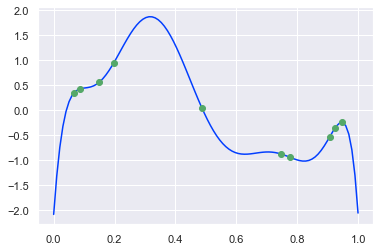

In [18]:
plt.plot(x_test, list(map(lambda x: linear(x, optimal_weights(x_train, y_train, 9)), x_test)), '-')
plt.plot(x_train, y_train, 'og')

## 2) Regularization

### 2.1) Error function

`err_regularization` takes `weights`, `inputs`, `targets` and `l` (regularization term) and computes sum-of-squares error with weights regularization

$$\widetilde{E}(\mathbf{w}) = \dfrac12\sum^N_{n=1}\{y(x_n, \mathbf{w}) − t_n\}^2 + \dfrac\lambda2\lVert \mathbf{w}\rVert^2$$

In [19]:
def err_regularization(weights, inputs, targets, l):
    assert(len(inputs) == len(targets))
    regul = 0.5 * l * weights.dot(weights)
    res = err(weights, inputs, targets) + regul
    return res

`erms_regularization` is a regularization version of a root mean squares error

In [20]:
def erms_regularization(weights, inputs, targets, l):
    assert(len(inputs) == len(targets))
    regul = 0.5 * l * weights.dot(weights)
    res = erms(weights, inputs, targets) + regul
    return res

### 2.2) Optimization

`optimal_weights_regularization` takes `inputs`, `targets`, `M` (number of weights) and `l` (regularization term)  as parameters and returns optimal weights (with regularization) for this data

In [34]:
def optimal_weights_regularization(inputs, targets, M, l):
    X = np.array([
        [
            x**j
            for j in range(M + 1)
        ] 
        for x in inputs
    ])
    res = np.linalg.pinv(l * np.eye(M + 1) + X.T @ X) @ X.T @ np.array(targets)
    return res

### 2.3) Test with regularization

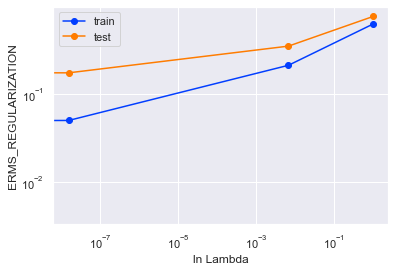

In [35]:
def test_all_regularization(ls, M, x_train, y_train, x_test, y_test):
    
    results_train = []
    results_test = []
    all_weights = []
    
    for l in ls:
        weights = optimal_weights_regularization(x_train, y_train, M, l)
        all_weights.append(weights)
        error_train = erms_regularization(weights, x_train, y_train, l)
        error_test = erms_regularization(weights, x_test, y_test, l)
        results_train.append(error_train)
        results_test.append(error_test)
    return results_train, results_test, all_weights

ls = [0, exp(-18), exp(-5), exp(0)]

r_tr_r, r_tt_r, all_weights_r = test_all_regularization(ls, 9, x_train, y_train, x_test, y_test)

plt.plot(ls, r_tr_r, '-o', label='train')
plt.plot(ls, r_tt_r, '-o', label='test')
plt.xlabel('ln Lambda')
plt.ylabel('ERMS_REGULARIZATION')
plt.legend()
plt.yscale('log')
plt.xscale('log')

##### Weights for `M=9` with regularization terms `0`, `exp(-18)`, `exp(-5)`, `exp(0)`

In [38]:
print(pd.DataFrame(np.transpose(all_weights_r)))

              0           1         2         3
0     -2.096154    0.699011  0.503543  0.328543
1     87.311247  -11.795682  0.743539 -0.389393
2  -1160.404329  121.043846 -2.425527 -0.353466
3   7385.602395 -335.150184 -1.908122 -0.232935
4 -22980.802157  217.987074 -0.795824 -0.127092
5  33683.388237  178.622525  0.106829 -0.046211
6 -13412.954928  -87.722827  0.719266  0.013218
7 -21744.518573 -148.839182  1.096707  0.055948
8  27098.892806  -12.387885  1.302133  0.085993
9  -8956.487195   78.207420  1.385740  0.106489


In [36]:
def plot_by_lambda(l):
    plt.plot(x_test, y_test, '-m')
    plt.plot(x_test, list(map(lambda x: linear(x, optimal_weights_regularization(x_train, y_train, 9, l)), x_test)), '-')
    plt.plot(x_train, y_train, 'og')

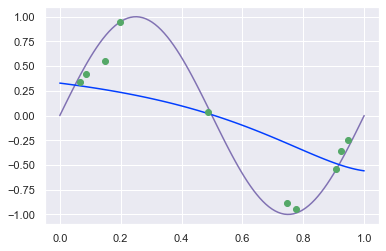

In [42]:
plot_by_lambda(exp(0))

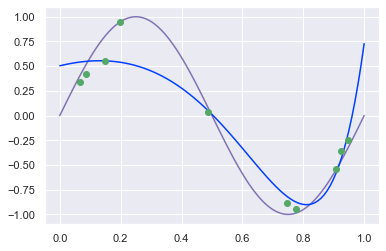

In [39]:
plot_by_lambda(exp(-5))

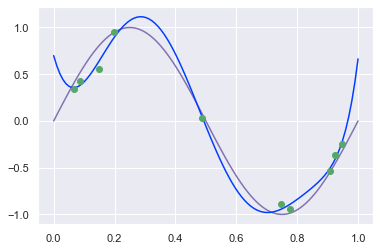

In [40]:
plot_by_lambda(exp(-18))

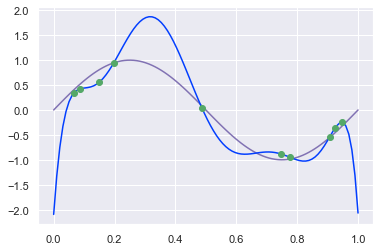

In [41]:
plot_by_lambda(0)

## 3) Model Selection

### 3.1) Cross-validation

`create_cross_validation_sets` takes `S` (number of sets) and data points `x_train`, `y_train` as parameters and returns array of sets in form `[x_sub_train, y_sub_train, x_validation, y_validation]` each

In [33]:
def create_cross_validation_sets(S, x_train, y_train):
    assert(len(x_train) == len(y_train))
    N = len(x_train)
    group_size = int(N/S)
    x_sub_train = [
        np.concatenate((x_train[:i], x_train[i + group_size:]))
        for i in range(S)
    ]
    y_sub_train = [
        np.concatenate((y_train[:i], y_train[i + group_size:]))
        for i in range(S)
    ]
    x_validation = [
        x_train[i:i + group_size]
        for i in range(S)
    ]
    y_validation = [
        y_train[i:i + group_size]
        for i in range(S)
    ]
    res = [x_sub_train, y_sub_train, x_validation, y_validation]
    return res

`best_model` takes `start_M`, `end_M` (low and high limits to search for `M`), `ls` (list of regularization terms) and `sets` (cross-validation sets) and should return `(top_M, top_l, top_result_test)` with `M`, `l` and result for the best model

M = 8 lambda = 1.522997974471263e-08 erms = 0.1768995052778984


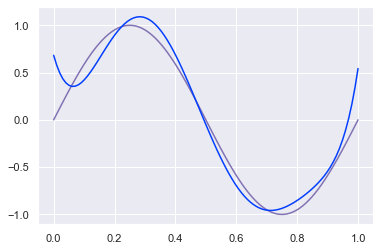

In [56]:
from itertools import product

def best_model(start_M, end_M, ls, sets):    
    S = len(sets)

    # Function that gets the regularized erms of a set of training data points and validation data points
    test_error = lambda set, M, l: erms_regularization(optimal_weights_regularization(set[0], set[1], M, l), set[2], set[3], l)    
    
    # Create array with tuples containing M, l and result from test 
    test_results = [
        [
            M, 
            l, 
            sum([ 
                test_error(set, M, l)
                for set in sets
            ]) / S
        ]
        for M, l in product(range(start_M, end_M + 1), ls)
    ]
    
    best = test_results[0]
    for test_result in test_results:
        # Compare the error and choose the lower
        if test_result[2] < best[2]:
            best = test_result
    
    return best


x_cross_train, y_cross_train, _, _ = generate_data(100) 

M, l, r = best_model(0, 9, [0, exp(-18), exp(-5), exp(0)], create_cross_validation_sets(10, x_cross_train, y_cross_train))
print('M =', M, 'lambda =', l, 'erms =', r)

plt.plot(x_test, y_test, '-m')
plt.plot(x_test, list(map(lambda x: linear(x, optimal_weights_regularization(x_train, y_train, M, l)), x_test)), '-')

## 4) Bayesian curve fitting

`phi` takes `x` (data point) and `M` (number of weights) as arguments and returns a vector of powers of `x` from `0` to `M`

In [66]:
def phi(x, M):
    res = np.array([
        x**j 
        for j in range(M)
    ])
    return res

`S` takes `alpha`, `beta`, `x` (all data points), and `M` as arguments and returns a matrix `S` that is used to compute `mean` and `variance`

In [68]:
def S(alpha, beta, x, M):
    phi_sum = np.sum([
        np.outer(phi(x_n, M), phi(x_n, M))
        for x_n in x
    ], 0)
    res = np.linalg.inv(alpha * np.eye(M) + beta * phi_sum)
    return res 

`mean` takes `alpha`, `beta`, `x_star` (new point), `x` (all data points), `t` (target values), and `M` and computes mean for the Gaussian distribution

In [69]:
def mean(alpha, beta, x_star, x, t, M):
    phi_target_sum = np.sum([
        phi(x_n, M) * t_n
        for x_n, t_n in zip(x, t)
    ], 0)
    res = beta * phi(x_star, M).T @ S(alpha, beta, x, M) @ phi_target_sum
    return res

`variance` takes `alpha`, `beta`, `x_star` (new point), `x` (all data points), `t` (target values), and `M` and computes variance for the Gaussian variance

In [70]:
def variance(alpha, beta, x_star, x, t, M):
    res = 1 / beta + phi(x_star, M).T @ S(alpha, beta, x, M) @ phi(x_star, M)
    return res

### 4.1) Display results

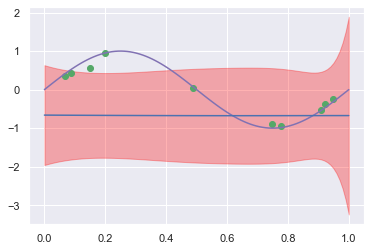

In [73]:
alpha = 0.05
beta = 1.1
M = 9

means = np.array(list(map(lambda x: mean(alpha, beta, x, x_train, y_train, M), x_test)))
variances = np.array(list(map(lambda x: variance(alpha, beta, x, x_train, y_train, M), x_test)))

plt.plot(x_train, y_train, 'og')
plt.plot(x_test, y_test, '-m')
plt.plot(x_test, means, '-b')
plt.fill_between(x_test, means + variances, means - variances, color='red', alpha=0.3)